# 🎯 03 - RFM Segmentation

**Week 2 Deliverable**: RFM Segmentation with Customer Profiles

## Objectives
1. Calculate RFM metrics (Recency, Frequency, Monetary)
2. Create RFM scores using quantile binning
3. Segment customers based on RFM scores
4. Analyze and visualize segment profiles

---

## 1. Setup & Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

print('Libraries loaded!')

Libraries loaded!


In [2]:
# Load cleaned data
df = pd.read_csv('../data/processed/online_retail_clean.csv', parse_dates=['InvoiceDate'])
print(f'Loaded {len(df):,} records')
print(f'Unique customers: {df["CustomerID"].nunique():,}')

Loaded 392,692 records
Unique customers: 4,338


## 2. Calculate RFM Metrics

In [3]:
# Set reference date (1 day after last transaction)
reference_date = df['InvoiceDate'].max() + timedelta(days=1)
print(f'Reference date: {reference_date}')

Reference date: 2011-12-10 12:50:00


In [4]:
# Calculate RFM metrics per customer
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'Revenue': 'sum'  # Monetary
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm = rfm.reset_index()

print(f'RFM table shape: {rfm.shape}')
rfm.head(10)

RFM table shape: (4338, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,19,1,1757.55
4,12350,310,1,334.40
5,12352,36,8,2506.04
6,12353,204,1,89.00
7,12354,232,1,1079.40
8,12355,214,1,459.40
9,12356,23,3,2811.43


In [5]:
# RFM Statistics
print('=== RFM Statistics ===')
rfm.describe().round(2)

=== RFM Statistics ===


,CustomerID,Recency,Frequency,Monetary
count,4338.00,4338.00,4338.00,4338.00
mean,15300.41,92.54,4.27,2048.69
std,1721.81,100.01,7.70,8985.23
min,12346.00,1.00,1.00,3.75
25%,13813.25,18.00,1.00,306.48
50%,15299.50,51.00,2.00,668.57
75%,16778.75,142.00,5.00,1660.60
max,18287.00,374.00,209.00,280206.02


## 3. RFM Distributions

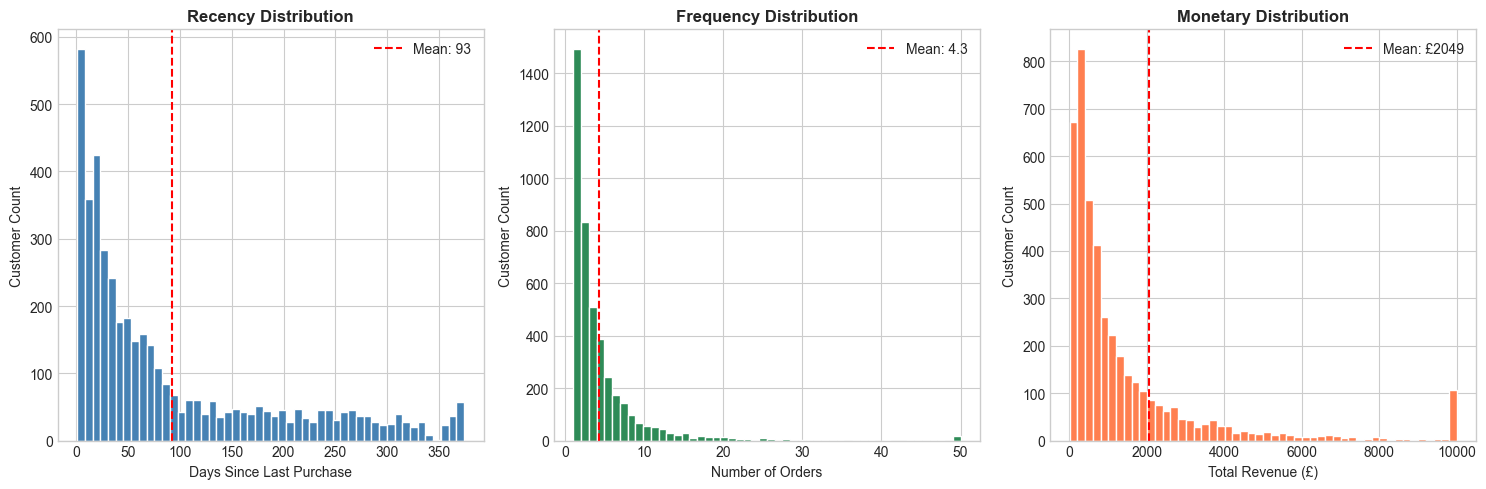

In [6]:
# RFM Distribution plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Recency
rfm['Recency'].hist(bins=50, ax=axes[0], color='steelblue', edgecolor='white')
axes[0].set_title('Recency Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Days Since Last Purchase')
axes[0].set_ylabel('Customer Count')
axes[0].axvline(rfm['Recency'].mean(), color='red', linestyle='--', label=f'Mean: {rfm["Recency"].mean():.0f}')
axes[0].legend()

# Frequency
rfm['Frequency'].clip(upper=50).hist(bins=50, ax=axes[1], color='seagreen', edgecolor='white')
axes[1].set_title('Frequency Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Number of Orders')
axes[1].set_ylabel('Customer Count')
axes[1].axvline(rfm['Frequency'].mean(), color='red', linestyle='--', label=f'Mean: {rfm["Frequency"].mean():.1f}')
axes[1].legend()

# Monetary
rfm['Monetary'].clip(upper=10000).hist(bins=50, ax=axes[2], color='coral', edgecolor='white')
axes[2].set_title('Monetary Distribution', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Total Revenue (£)')
axes[2].set_ylabel('Customer Count')
axes[2].axvline(rfm['Monetary'].mean(), color='red', linestyle='--', label=f'Mean: £{rfm["Monetary"].mean():.0f}')
axes[2].legend()

plt.tight_layout()
plt.savefig('../data/processed/rfm_distributions.png', dpi=300)
plt.show()

## 4. Calculate RFM Scores

In [7]:
# Create RFM scores using quintiles (1-5)
# For Recency: lower is better, so reverse the score
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=5, labels=[5, 4, 3, 2, 1], duplicates='drop')

# For Frequency: higher is better
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')

# For Monetary: higher is better
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')

# Convert to int
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

rfm.head(10)

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
0,12346,326,1,77183.60,1,1,5
1,12347,2,7,4310.00,5,5,5
2,12348,75,4,1797.24,2,4,4
3,12349,19,1,1757.55,4,1,4
4,12350,310,1,334.40,1,1,2
5,12352,36,8,2506.04,3,5,5
6,12353,204,1,89.00,1,1,1
7,12354,232,1,1079.40,1,1,4
8,12355,214,1,459.40,1,1,2
9,12356,23,3,2811.43,4,3,5


In [8]:
# Create combined RFM score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Total'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']

print(f'Unique RFM Scores: {rfm["RFM_Score"].nunique()}')
rfm['RFM_Score'].value_counts().head(10)

Unique RFM Scores: 118


RFM_Score
555    347
111    183
455    177
121    153
112    127
444    118
122     90
544     85
233     83
344     82
Name: count, dtype: int64

## 5. Customer Segmentation

In [9]:
# Define customer segments based on RFM scores
def assign_segment(row):
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    
    # Champions - High R, High F, High M
    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    
    # Loyal Customers - High F
    elif f >= 4:
        return 'Loyal Customers'
    
    # Potential Loyalists - High R, Medium-High F
    elif r >= 4 and f >= 2:
        return 'Potential Loyalists'
    
    # New Customers - Very High R, Low F
    elif r >= 4 and f == 1:
        return 'New Customers'
    
    # Promising - Medium R, Low F
    elif r >= 3 and f == 1:
        return 'Promising'
    
    # Need Attention - Medium R, Medium F
    elif r >= 3 and f >= 2:
        return 'Need Attention'
    
    # About to Sleep - Low-Medium R, Low F
    elif r == 2 and f <= 2:
        return 'About to Sleep'
    
    # At Risk - Low R, High F
    elif r <= 2 and f >= 4:
        return 'At Risk'
    
    # Cannot Lose - Low R, Very High F and M
    elif r <= 2 and f >= 4 and m >= 4:
        return 'Cannot Lose'
    
    # Hibernating - Very Low R, Low F
    elif r <= 2 and f <= 2:
        return 'Hibernating'
    
    # Lost - Very Low R and F
    elif r == 1 and f == 1:
        return 'Lost'
    
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(assign_segment, axis=1)
print(f'Segments created: {rfm["Segment"].nunique()}')

Segments created: 9


In [10]:
# Segment distribution
segment_counts = rfm['Segment'].value_counts()
segment_pct = (segment_counts / len(rfm) * 100).round(1)

segment_summary = pd.DataFrame({
    'Count': segment_counts,
    'Percentage': segment_pct
})

segment_summary

,Count,Percentage
Segment,,
Champions,957,22.1
Loyal Customers,778,17.9
Hibernating,664,15.3
Potential Loyalists,492,11.3
About to Sleep,401,9.2
Need Attention,373,8.6
Others,368,8.5
Promising,164,3.8
New Customers,141,3.3


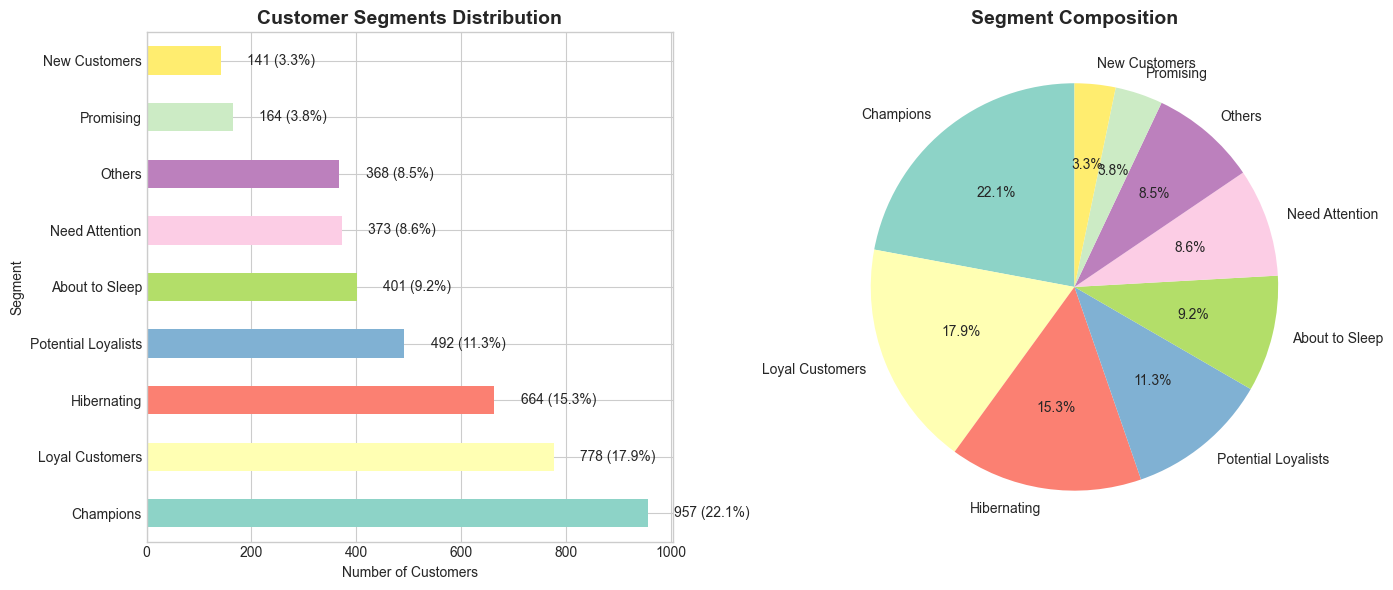

In [11]:
# Segment distribution visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart
colors = plt.cm.Set3(np.linspace(0, 1, len(segment_counts)))
segment_counts.plot(kind='barh', ax=axes[0], color=colors)
axes[0].set_title('Customer Segments Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Customers')
axes[0].set_ylabel('Segment')

# Add values
for i, v in enumerate(segment_counts.values):
    axes[0].text(v + 50, i, f'{v:,} ({segment_pct.values[i]:.1f}%)', va='center')

# Pie chart
axes[1].pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90)
axes[1].set_title('Segment Composition', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/processed/rfm_segment_distribution.png', dpi=300)
plt.show()

## 6. Segment Profiles

In [12]:
# Segment profiles
segment_profiles = rfm.groupby('Segment').agg({
    'CustomerID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'sum'],
    'RFM_Total': 'mean'
}).round(2)

segment_profiles.columns = ['Customers', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Total_Revenue', 'Avg_RFM']
segment_profiles['Revenue_Pct'] = (segment_profiles['Total_Revenue'] / segment_profiles['Total_Revenue'].sum() * 100).round(1)
segment_profiles = segment_profiles.sort_values('Total_Revenue', ascending=False)

segment_profiles

,Customers,Avg_Recency,Avg_Frequency,Avg_Monetary,Total_Revenue,Avg_RFM,Revenue_Pct
Segment,,,,,,,
Champions,957,12.82,11.12,6051.87,5791640.74,13.92,65.2
Loyal Customers,778,73.04,5.01,1706.03,1327290.83,10.78,14.9
Potential Loyalists,492,17.12,2.01,1030.11,506813.63,9.64,5.7
Others,368,164.63,2.29,995.69,366413.24,7.36,4.1
Hibernating,664,278.08,1.06,475.09,315459.97,4.18,3.5
Need Attention,373,53.10,1.82,688.57,256835.96,8.00,2.9
About to Sleep,401,118.25,1.16,505.89,202862.18,5.60,2.3
Promising,164,53.91,1.00,419.15,68740.70,5.91,0.8
New Customers,141,18.50,1.00,362.78,51151.64,6.94,0.6


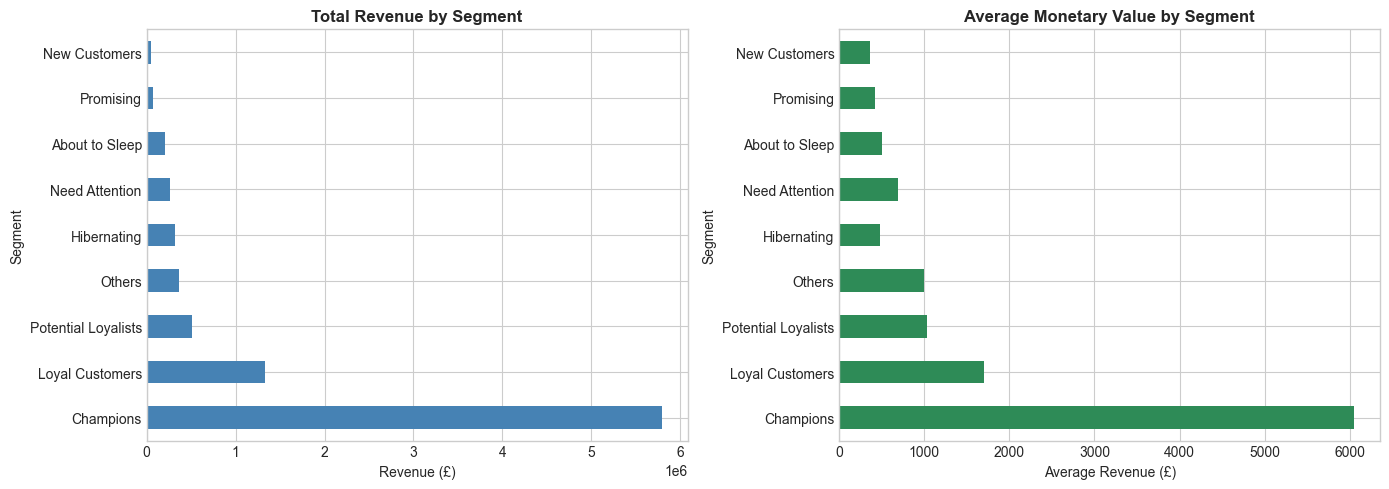

In [13]:
# Revenue contribution by segment
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Revenue bar
segment_profiles['Total_Revenue'].plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Total Revenue by Segment', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Revenue (£)')

# Avg Monetary bar
segment_profiles['Avg_Monetary'].plot(kind='barh', ax=axes[1], color='seagreen')
axes[1].set_title('Average Monetary Value by Segment', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Average Revenue (£)')

plt.tight_layout()
plt.savefig('../data/processed/rfm_segment_revenue.png', dpi=300)
plt.show()

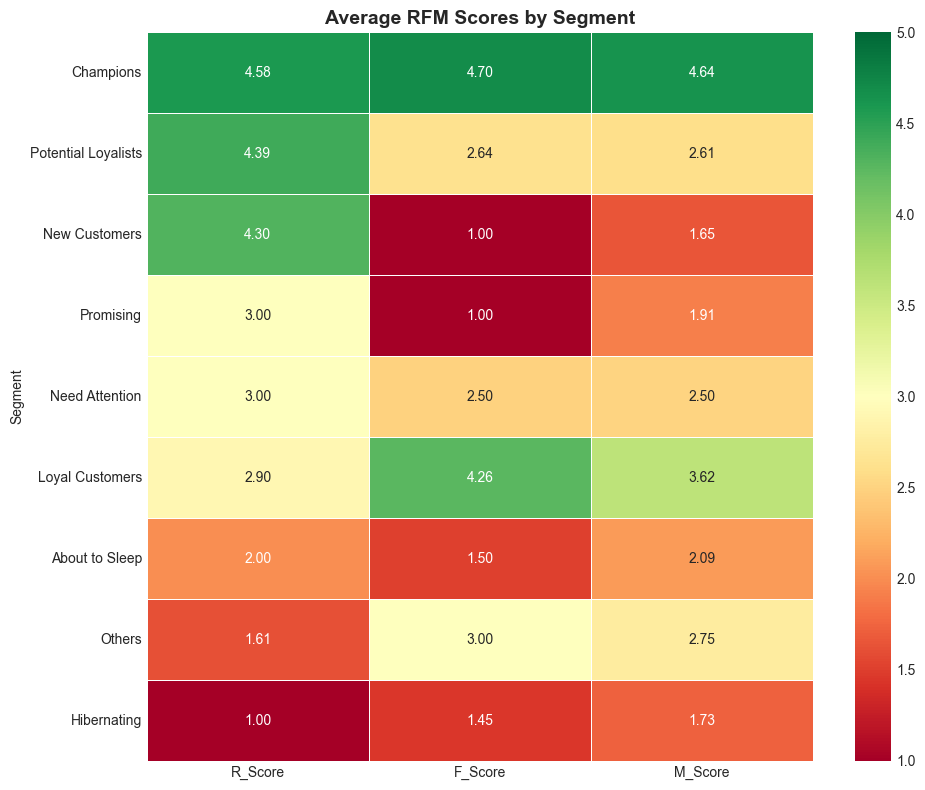

In [14]:
# RFM Score heatmap by segment
segment_rfm = rfm.groupby('Segment')[['R_Score', 'F_Score', 'M_Score']].mean()
segment_rfm = segment_rfm.sort_values('R_Score', ascending=False)

plt.figure(figsize=(10, 8))
sns.heatmap(segment_rfm, annot=True, fmt='.2f', cmap='RdYlGn', 
            center=3, vmin=1, vmax=5, linewidths=0.5)

plt.title('Average RFM Scores by Segment', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../data/processed/rfm_segment_heatmap.png', dpi=300)
plt.show()

## 7. RFM 3D Visualization

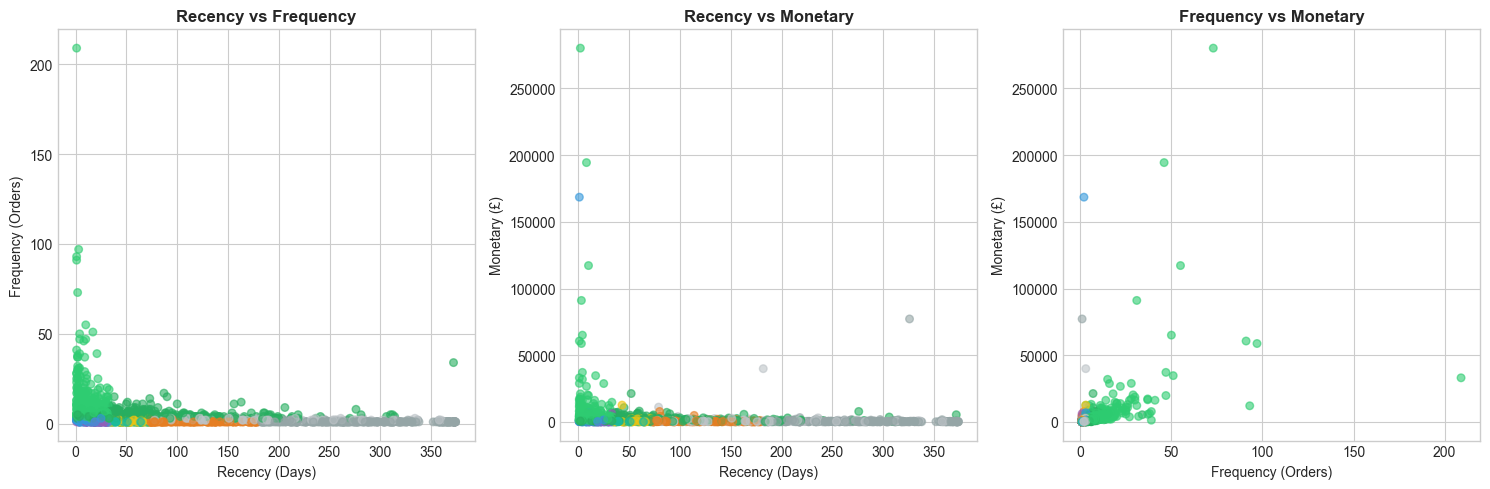

In [15]:
# Scatter plot matrix
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Sample for visualization
sample = rfm.sample(min(2000, len(rfm)))

# Define segment colors
segment_colors = {
    'Champions': '#2ecc71',
    'Loyal Customers': '#27ae60',
    'Potential Loyalists': '#3498db',
    'New Customers': '#9b59b6',
    'Promising': '#1abc9c',
    'Need Attention': '#f1c40f',
    'About to Sleep': '#e67e22',
    'At Risk': '#e74c3c',
    'Cannot Lose': '#c0392b',
    'Hibernating': '#95a5a6',
    'Lost': '#7f8c8d',
    'Others': '#bdc3c7'
}

colors = sample['Segment'].map(segment_colors)

# R vs F
axes[0].scatter(sample['Recency'], sample['Frequency'], c=colors, alpha=0.6, s=30)
axes[0].set_xlabel('Recency (Days)')
axes[0].set_ylabel('Frequency (Orders)')
axes[0].set_title('Recency vs Frequency', fontweight='bold')

# R vs M
axes[1].scatter(sample['Recency'], sample['Monetary'], c=colors, alpha=0.6, s=30)
axes[1].set_xlabel('Recency (Days)')
axes[1].set_ylabel('Monetary (£)')
axes[1].set_title('Recency vs Monetary', fontweight='bold')

# F vs M
axes[2].scatter(sample['Frequency'], sample['Monetary'], c=colors, alpha=0.6, s=30)
axes[2].set_xlabel('Frequency (Orders)')
axes[2].set_ylabel('Monetary (£)')
axes[2].set_title('Frequency vs Monetary', fontweight='bold')

plt.tight_layout()
plt.savefig('../data/processed/rfm_scatter.png', dpi=300)
plt.show()

## 8. Segment Recommendations

In [16]:
# Segment recommendations
recommendations = {
    'Champions': 'Reward them! Early access to new products, exclusive offers, loyalty programs',
    'Loyal Customers': 'Upsell higher value products, ask for referrals, engage in loyalty programs',
    'Potential Loyalists': 'Offer membership/loyalty programs, recommend related products',
    'New Customers': 'Provide onboarding support, early engagement, build relationship',
    'Promising': 'Create brand awareness, offer free trials, early bird discounts',
    'Need Attention': 'Reactivation campaigns, limited time offers, personalized recommendations',
    'About to Sleep': 'Win-back campaigns, share valuable content, reconnect with new products',
    'At Risk': 'Strong retention campaigns, personalized outreach, special offers',
    'Cannot Lose': 'Win them back urgently! Personal outreach, excellent service recovery',
    'Hibernating': 'Reactivation emails, special comeback offers, ask for feedback',
    'Lost': 'Try to win back with big offers, or move resources to other segments',
    'Others': 'Analyze further and create targeted campaigns'
}

rec_df = pd.DataFrame([
    {'Segment': seg, 'Customers': segment_counts.get(seg, 0), 'Recommendation': rec}
    for seg, rec in recommendations.items()
    if seg in segment_counts.index
])

rec_df = rec_df.merge(segment_profiles[['Total_Revenue']], left_on='Segment', right_index=True)
rec_df = rec_df.sort_values('Total_Revenue', ascending=False)

print('=== Segment Recommendations ===')
for _, row in rec_df.iterrows():
    print(f"\n{row['Segment']} ({row['Customers']:,} customers, £{row['Total_Revenue']:,.0f}):")
    print(f"  → {row['Recommendation']}")

=== Segment Recommendations ===

Champions (957 customers, £5,791,641):
  → Reward them! Early access to new products, exclusive offers, loyalty programs

Loyal Customers (778 customers, £1,327,291):
  → Upsell higher value products, ask for referrals, engage in loyalty programs

Potential Loyalists (492 customers, £506,814):
  → Offer membership/loyalty programs, recommend related products

Others (368 customers, £366,413):
  → Analyze further and create targeted campaigns

Hibernating (664 customers, £315,460):
  → Reactivation emails, special comeback offers, ask for feedback

Need Attention (373 customers, £256,836):
  → Reactivation campaigns, limited time offers, personalized recommendations

About to Sleep (401 customers, £202,862):
  → Win-back campaigns, share valuable content, reconnect with new products

Promising (164 customers, £68,741):
  → Create brand awareness, offer free trials, early bird discounts

New Customers (141 customers, £51,152):
  → Provide onboarding suppo

## 9. Key Metrics Summary

In [18]:
print('=' * 60)
print('RFM SEGMENTATION - KEY INSIGHTS')
print('=' * 60)

print('\n Customer Overview:')
print(f'   • Total customers: {len(rfm):,}')
print(f'   • Total revenue: £{rfm["Monetary"].sum():,.2f}')
print(f'   • Average customer value: £{rfm["Monetary"].mean():,.2f}')

print('\n Top Segments by Revenue:')
for i, (seg, data) in enumerate(segment_profiles.head(5).iterrows()):
    print(f'   {i+1}. {seg}: £{data["Total_Revenue"]:,.0f} ({data["Revenue_Pct"]:.1f}%)')

print('\n Segments Needing Attention:')
at_risk_segments = ['At Risk', 'Cannot Lose', 'Hibernating', 'Lost', 'About to Sleep']
for seg in at_risk_segments:
    if seg in segment_counts.index:
        count = segment_counts[seg]
        print(f'   • {seg}: {count:,} customers ({count/len(rfm)*100:.1f}%)')

print('\n High-Value Segments:')
valuable_segments = ['Champions', 'Loyal Customers', 'Potential Loyalists']
total_valuable = sum(segment_counts.get(seg, 0) for seg in valuable_segments)
print(f'   • Combined: {total_valuable:,} customers ({total_valuable/len(rfm)*100:.1f}%)')

print('\n' + '=' * 60)

RFM SEGMENTATION - KEY INSIGHTS

 Customer Overview:
   • Total customers: 4,338
   • Total revenue: £8,887,208.89
   • Average customer value: £2,048.69

 Top Segments by Revenue:
   1. Champions: £5,791,641 (65.2%)
   2. Loyal Customers: £1,327,291 (14.9%)
   3. Potential Loyalists: £506,814 (5.7%)
   4. Others: £366,413 (4.1%)
   5. Hibernating: £315,460 (3.5%)

 Segments Needing Attention:
   • Hibernating: 664 customers (15.3%)
   • About to Sleep: 401 customers (9.2%)

 High-Value Segments:
   • Combined: 2,227 customers (51.3%)



## 10. Save RFM Data

In [19]:
# Save RFM data
rfm.to_csv('../data/features/rfm_segments.csv', index=False)
segment_profiles.to_csv('../data/features/segment_profiles.csv')

print('RFM data saved!')
print('  - data/features/rfm_segments.csv')
print('  - data/features/segment_profiles.csv')

RFM data saved!
  - data/features/rfm_segments.csv
  - data/features/segment_profiles.csv


## Next Steps

Continue to **Notebook 04 - Feature Engineering** to:
- Create additional behavioral features
- Build feature matrix for CLV modeling
- Prepare data for machine learning